I will do a handwritten digit classification as a starting poihnt 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), # this converts the image to tensor
    transforms.Normalize((0.5,),(0.5,)) #mean 0.5 and std dev 0.5
])

Loading the dataset :

In [3]:

train_dataset = torchvision.datasets.MNIST(root='.', train=True,
                                           download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='.', train=False,
                                          download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:07<00:00, 1.30MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 93.4kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 555kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.73MB/s]


Loading the datatset : 

Batching : loads multiple samples at once 

shuffles : shuffles the data to avoid order based pattern memorization 

In [4]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

Too see some samples :

In [6]:
def show_image(im):
    im = im/2 + 0.5 
    npim = im.numpy()
    plt.imshow(np.transpose(npim, (1, 2, 0)), cmap='grey') ## from C H W of tensors to H C W FOR matplotlib
    plt.axis('off')
    plt.show()

torch.Size([100, 1, 28, 28])
torch.Size([100])


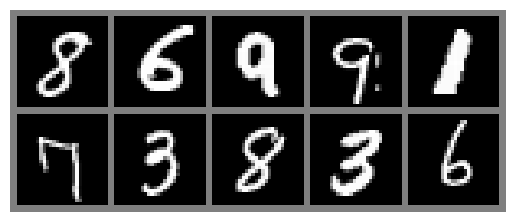

Labels: 8 6 9 9 1 7 3 8 3 6


In [10]:

# Get some random training images
dataiter = iter(train_loader) # itearates over the data 
images, labels = next(dataiter) # returns a batch and labels

print(images.shape)
print(labels.shape)

# Show images
show_image(torchvision.utils.make_grid(images[:10], nrow=5)) # takes first 8
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(10))) # takes first labels


Lets define the model now :

Description :

convolution layer will take (1, 28, 28) as input , evaluate every 3x3 patch and return an output of (32, 26 , 26)

pool layer will take feature map of each 2x2 grid and take the strongest activation : 
input(32,26,26) and output (32,13,13)

convolution layer 2 will generate 64 features from the 32, making more complex features 
input(32,13,13) and output (64, 11, 11)

Will pool again to reduce to (64, 5 , 5)


Now need to flatten to feed to a dense layer( linear), that will get a 1600 feats for each image, and generate 64 abstract feats that will then be fed to the output layer to 
classify among the 10 labels

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size=3) # 1 channel in input , will output 32 feats 
        self.pool = nn.MaxPool2d(2,2) # will consider 2x2 patches
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)## will take 32 feats and generate 64
        self.dense1 = nn.Linear(64*25, 64) #will take 64*25 feats and output 64
        self.output = nn.Linear(64,10) ## will take the 64 abstract features and output probability of each label (softmax ish ?) 

    def forward(self, X):
        X = self.pool(torch.relu(self.conv1(X))) # conv1 + relu + pool : conv generates 32 feats for 
        X = self.pool(torch.relu(self.conv2(X)))
        X = X.view(-1 , 64*25) # flattens the tensor to have 1600 features for each image 
        X = torch.relu(self.dense1(X)) # relu in the sense layer
        X = self.output(X)
        return X 
        

model = CNN()

In [15]:
criterion = nn.CrossEntropyLoss()  # for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

Each parameter has a .grad attribute . When output and label is passed, loss func calculated the grad in .backward() and stores grads to .grads of each param 

The training :

In [18]:
for epoch in range(25):
    model.train()
    running_loss = 0.0  # sum of losses for this epoch
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  # add batch loss to total
    
    epoch_loss = running_loss / len(train_loader)  # average loss
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")



Epoch 1, Loss: 0.0042
Epoch 2, Loss: 0.0026
Epoch 3, Loss: 0.0043
Epoch 4, Loss: 0.0015
Epoch 5, Loss: 0.0011
Epoch 6, Loss: 0.0038
Epoch 7, Loss: 0.0054
Epoch 8, Loss: 0.0036
Epoch 9, Loss: 0.0008
Epoch 10, Loss: 0.0002
Epoch 11, Loss: 0.0000
Epoch 12, Loss: 0.0012
Epoch 13, Loss: 0.0083
Epoch 14, Loss: 0.0033
Epoch 15, Loss: 0.0015
Epoch 16, Loss: 0.0018
Epoch 17, Loss: 0.0030
Epoch 18, Loss: 0.0013
Epoch 19, Loss: 0.0026
Epoch 20, Loss: 0.0022
Epoch 21, Loss: 0.0021
Epoch 22, Loss: 0.0024
Epoch 23, Loss: 0.0016
Epoch 24, Loss: 0.0011
Epoch 25, Loss: 0.0033


Loss functions  knows the weights to calculate gradients for because pythorch has an inbuilt computation graph and loss just back tracks from that

In [19]:
model.eval() # evaluation mode , no changes to the model 
total = 0 
correct = 0 
wrong = 0
with torch.no_grad():
    for images , labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs,1) # in axis 1 (columns), we look for the highest value in tensor, stores index of the max
        total += labels.size(0)
        correct += (labels == predicted).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")





Test Accuracy: 99.05%
